# Projet 5 - Segmentez des clients d'un site e-commerce

Segmenter les clients d'un site de e-commerce, et proposer des pistes d'action

# 1 - Analyse exploratoire

## Import des librairies

In [122]:
# Core / utilitaires
import os
import warnings

import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# SciPy (dendrogramme / linkage si besoin)
from scipy.cluster.hierarchy import dendrogram

# scikit-learn — clustering, métriques, prétraitement, voisins, jeux de données
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_blobs, make_moons

# Supprimer/masquer les warnings
warnings.filterwarnings("ignore")

## Import du csv généra à partir des bases de données et de Dbeaver

In [123]:
df = pd.read_csv("../data/processed/customer_rfm_final.csv")
df

,customer_unique_id,customer_id,mean_price,average_reviewed_score,recency_score,frequency_score,monetary_score,rfm_score,rfm_composite_score
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,124.99,4.0,1,1,2,112,1.3
1,290c77bc529b7ac935b93aa66c333dc3,18955e83d337fd6b2def6b18a428ac77,289.00,5.0,1,1,3,113,1.6
2,060e732b5b29e8181a18229c7b0b2b5e,4e7b3e00288586ebd08712fdd0374a03,139.94,5.0,1,1,2,112,1.3
3,259dac757896d24d7702b9acbbff3f3c,b2b6027bc5c5109e529d4dc6358b12c3,149.94,5.0,1,1,2,112,1.3
4,345ecd01c38d18a9036ed96c73b8d066,4f2d8ab171c80ec8364f7c12e35b23ad,230.00,5.0,1,1,3,113,1.6
...,...,...,...,...,...,...,...,...,...
98661,1a29b476fee25c95fbafc67c5ac95cf8,17ddf5dd5d51696bb3d7c6291687be6f,74.90,4.0,1,1,1,111,1.0
98662,d52a67c98be1cf6a5c84435bd38d095d,e7b71a9017aa05c9a7fd292d714858e8,114.90,5.0,1,1,2,112,1.3
98663,e9f50caf99f032f0bf3c55141f019d99,5e28dfe12db7fb50a4b2f691faecea5e,37.00,1.0,1,1,1,111,1.0
98664,73c2643a0a458b49f58cea58833b192e,56b18e2166679b8a959d72dd06da27f9,689.00,5.0,1,1,4,114,1.9


Ici on drop la colonne customer_unique_id et on drop les colonnes id et conserve uniquement les features intéressantes

In [124]:
df = df[['mean_price', 'average_reviewed_score', 'recency_score', 'frequency_score', 'monetary_score']]
df

,mean_price,average_reviewed_score,recency_score,frequency_score,monetary_score
0,124.99,4.0,1,1,2
1,289.00,5.0,1,1,3
2,139.94,5.0,1,1,2
3,149.94,5.0,1,1,2
4,230.00,5.0,1,1,3
...,...,...,...,...,...
98661,74.90,4.0,1,1,1
98662,114.90,5.0,1,1,2
98663,37.00,1.0,1,1,1
98664,689.00,5.0,1,1,4


In [125]:
# Calcul des valeurs manquantes par colonne
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [126]:
missing_values_table(df)

Your selected dataframe has 5 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
average_reviewed_score,749,0.8


In [127]:
df.shape

(98666, 5)

In [128]:
df.info

<bound method DataFrame.info of        mean_price  average_reviewed_score  recency_score  frequency_score  \
0          124.99                     4.0              1                1   
1          289.00                     5.0              1                1   
2          139.94                     5.0              1                1   
3          149.94                     5.0              1                1   
4          230.00                     5.0              1                1   
...           ...                     ...            ...              ...   
98661       74.90                     4.0              1                1   
98662      114.90                     5.0              1                1   
98663       37.00                     1.0              1                1   
98664      689.00                     5.0              1                1   
98665       13.99                     5.0              1                1   

       monetary_score  
0                  

In [129]:
df.describe

<bound method NDFrame.describe of        mean_price  average_reviewed_score  recency_score  frequency_score  \
0          124.99                     4.0              1                1   
1          289.00                     5.0              1                1   
2          139.94                     5.0              1                1   
3          149.94                     5.0              1                1   
4          230.00                     5.0              1                1   
...           ...                     ...            ...              ...   
98661       74.90                     4.0              1                1   
98662      114.90                     5.0              1                1   
98663       37.00                     1.0              1                1   
98664      689.00                     5.0              1                1   
98665       13.99                     5.0              1                1   

       monetary_score  
0                

In [130]:
df.columns.to_list()

['mean_price',
 'average_reviewed_score',
 'recency_score',
 'frequency_score',
 'monetary_score']

In [131]:
df.isnull().sum()

mean_price                  0
average_reviewed_score    749
recency_score               0
frequency_score             0
monetary_score              0
dtype: int64

In [132]:
print(df.shape)
df.nunique()

(98666, 5)


mean_price                7091
average_reviewed_score      11
recency_score                1
frequency_score              1
monetary_score               5
dtype: int64

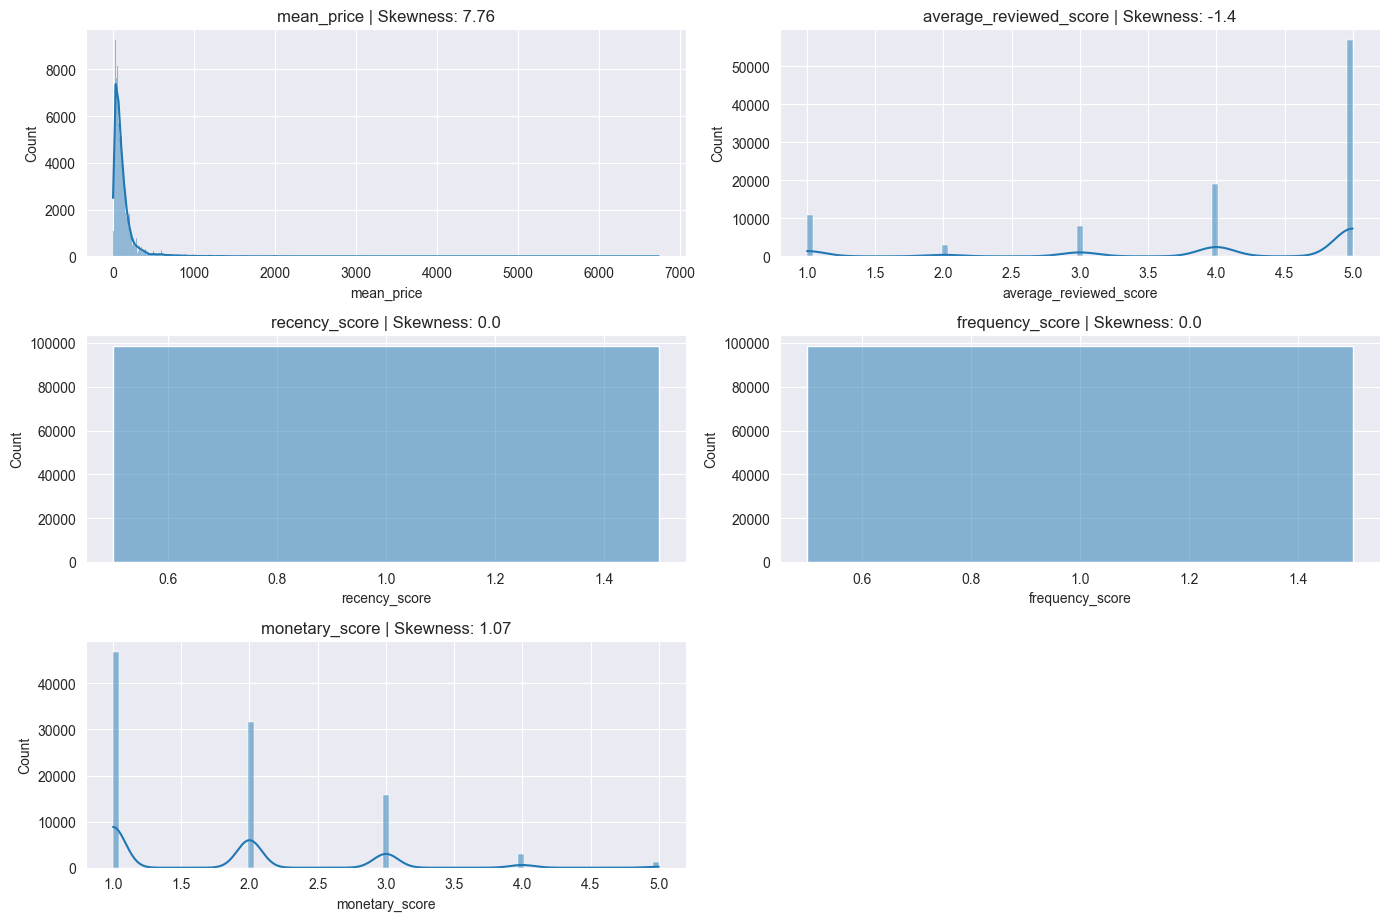

In [133]:
sns.set_style("darkgrid")

numerical_columns = df.select_dtypes(include=["int64", "float64"]).columns

plt.figure(figsize=(14, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, idx)
    sns.histplot(df[feature], kde=True)
    plt.title(f"{feature} | Skewness: {round(df[feature].skew(), 2)}")

plt.tight_layout()
plt.show()

# 2 - Clustering

Prérequis de le section :
- avoir sélectionné des features intéressantes pour le clustering : fait. Voici les features ['mean_price', 'average_reviewed_score', 'recency_score', 'frequency_score', 'monetary_score']
- acquis les bases théoriques nécessaires pour pouvoir réaliser et interpréter un clustering

A la fin de cette étape je devrai:
- avoir réalisé un notebook avec différentes simulations d'algortihmes de clustering

Etapes : 
- 1) Réalisez d’abord un clustering de type k-means avec un nombre de clusters relativement faible (entre 3 et 6) afin de vous familiariser avec la démarche d’analyse.
- 2) Proposez un nombre optimal de clusters en utilisant une méthode data-driven de votre choix (plusieurs méthodes existent dans la littérature) ainsi qu’en utilisant une méthode plus orientée métier.
- 3) Justifiez clairement et avec des métriques quantitatives la qualité de votre clustering (k-means ou autre).
- 4) Caractérisez vos clusters en établissant le lien entre chaque cluster et vos features en entrée de l’algorithme.
- 5) Il est toujours préférable de légèrement perdre en performance de clustering si cela permet de significativement gagner en tangibilité métier des différents clusters.

On crée un subset de 10 000 valeurs afin de réduire la puissance de calcul nécessaire au déroulement du programme

## Etape 1) Réalisation d'un clustering de type k-means avec un nombre relativement faible de clusters 

On réalise un échantillon représentatif de notre dataset afin d'avoir à trairer moins de valeurs. On pourra donc exlporer nos données plus rapidement et tester les modèles sans les appliquer au dataset complet, et ainsi gagner du temps et du coût de calcul.

In [134]:
X_subset = df.sample(10000)
X_subset.dropna(inplace=True)
len(X_subset)

9927

## Etape 2) Proposez un nombre optimal de clusters en utilisant une méthode data-driven de votre choix (plusieurs méthodes existent dans la littérature) ainsi qu’en utilisant une méthode plus orientée métier.

### A - Détermination du nombre de clusters par le dendrogram

In [135]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

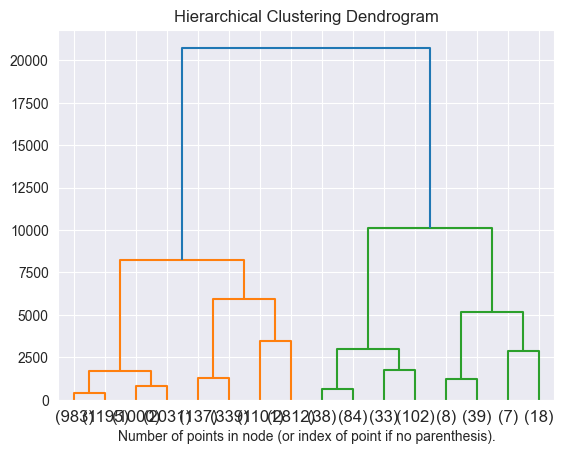

In [136]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X_subset)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

Avec le dendromgram visuellement, on voit qu'il y a 3 grands clusters qui se dessinent, voire 4. 

### B - Détermination du nombre de clusters par le coefficient de silhouette

Mesure :

- La qualité de la séparation entre les clusters
- Pour chaque point : "Est-ce qu'il est bien dans son cluster OU devrait-il être dans un autre ?"
silhouette(i) = (b - a) / max(a, b)

- **a** = distance moyenne aux points du même cluster
- **b** = distance moyenne aux points du cluster le plus proche

Valeurs :
- **+1** : Point parfaitement dans son cluster
- **0** : Point à la frontière entre deux clusters
- **-1** : Point probablement mal classifié

Avantages 
- Mesure directement la **qualité du clustering**
- Plus intuitif : un score élevé = bon clustering
- Détecte le sur-clustering (trop de clusters)

Inconvénients
- **Beaucoup plus lent** (O(n²) vs O(n))
- Ne fonctionne pas avec k=1
- Peut favoriser des clusters de tailles égales

K=2, Silhouette Score: 0.880
K=3, Silhouette Score: 0.762
K=4, Silhouette Score: 0.654
K=5, Silhouette Score: 0.650
K=6, Silhouette Score: 0.617
K=7, Silhouette Score: 0.616


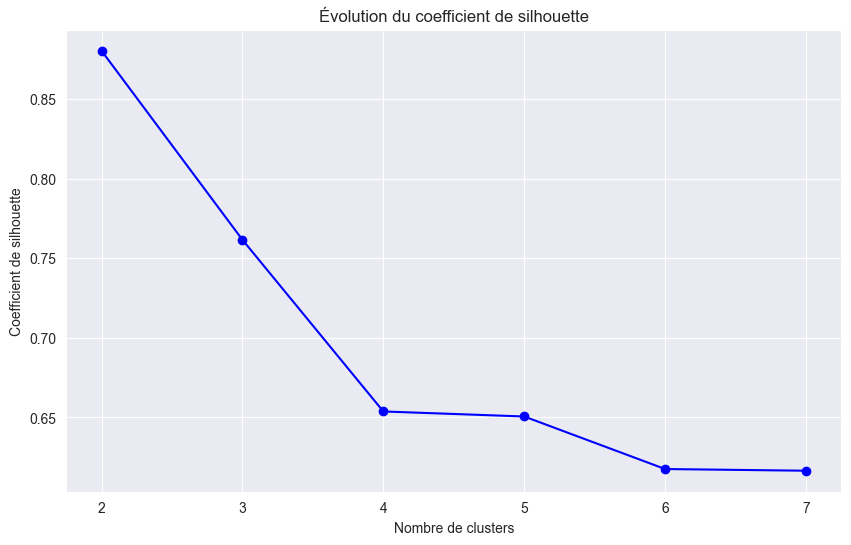

In [137]:
# Tester différents nombres de clusters
silhouette_scores = []
k_range = range(2, 8)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_subset)
    score = silhouette_score(X_subset, labels)
    silhouette_scores.append(score)
    print(f"K={k}, Silhouette Score: {score:.3f}")

# Visualiser
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'bo-')
plt.xlabel('Nombre de clusters')
plt.ylabel('Coefficient de silhouette')
plt.title('Évolution du coefficient de silhouette')
plt.grid(True)
plt.show()

### C - Détermination du nombre de clusters par la méthode du coude

Ce que mesure la méthode du coude :
- **La compacité** des clusters
- Somme des distances carrées entre chaque point et son centroïde

 Formule :

Inertie = Σ ||xi - μj||²
xi étant un point de données, et μj étant le centroïde du cluster

Principe :
L'inertie diminue toujours quand k augmente (minimum à k=n). On cherche le "coude" de la courbe = point où l'amélioration devient marginale.
Avantages ✅

Très rapide (déjà calculée par KMeans)
Fonctionne dès k=1
Simple à implémenter

Inconvénients ❌

Le "coude" est souvent subjectif
Ne mesure pas la séparation entre clusters
Continue à diminuer indéfiniment

Text(0.5, 1.0, 'Méthode du coude')

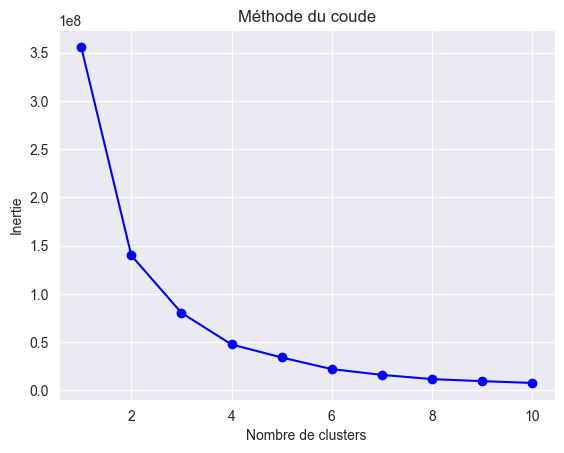

In [138]:
# Tester différents nombres de clusters
inertias = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_subset)
    inertias.append(kmeans.inertia_)

# Visualiser la courbe
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode du coude')

D'après la méthode du coude, on trouve un nombre de clusters autour de 4

Une bonne pratique pour plus tard peut-être de :    

1. Utiliser la méthode du coude pour une première estimation rapide.  
    → Identifie k ∈ {3, 4, 5} par exemple.  

2. Silhouette pour affiner sur cette plage.  
    for k in [3, 4, 5]:   

### D - Visualisation des clusters

In [139]:
kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(X_subset)
kmeans.labels_

array([0, 0, 1, ..., 1, 0, 3], shape=(9927,), dtype=int32)

La valeur labels contient les clusters pour chaque individu.

In [140]:
X_subset.head(3)
X_subset['cluster'] = kmeans.labels_
X_subset

,mean_price,average_reviewed_score,recency_score,frequency_score,monetary_score,cluster
85061,205.000,5.0,1,1,3,0
3737,189.900,5.0,1,1,3,0
24828,119.900,5.0,1,1,2,1
44937,24.500,3.0,1,1,1,1
9451,147.900,4.0,1,1,2,1
...,...,...,...,...,...,...
18572,199.000,5.0,1,1,3,0
71893,56.990,4.0,1,1,1,1
77797,18.995,1.0,1,1,1,1
27670,249.900,5.0,1,1,3,0


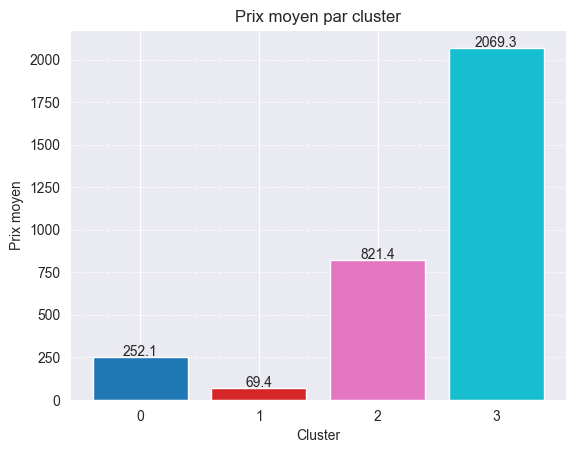

In [141]:
moyennes = X_subset.groupby('cluster')['mean_price'].mean()

# Création du barchart
# Palette de couleurs (autant que de clusters)
colors = plt.cm.tab10(np.linspace(0, 1, len(moyennes)))

# Création du barchart
plt.bar(moyennes.index, moyennes.values, color=colors)

# Ajout des labels sur chaque barre
for i, val in enumerate(moyennes.values):
    plt.text(moyennes.index[i], val + 5, f'{val:.1f}', ha='center', fontsize=10)

# Paramètres du graphique
plt.xlabel('Cluster')
plt.ylabel('Prix moyen')
plt.title('Prix moyen par cluster')
plt.xticks(moyennes.index)  # S'assurer que chaque cluster est affiché
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Les gens du groupe 2 sont les gros acheteurs, alors que le groupe 3 correspoondent aux petits achats

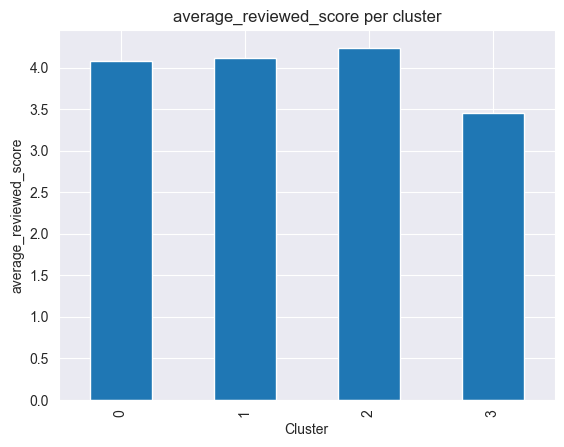

In [142]:
moyennes = X_subset.groupby('cluster')['average_reviewed_score'].mean()

# La façon la plus simple
moyennes.plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('average_reviewed_score')
plt.title('average_reviewed_score per cluster')
plt.show()

le cluster ne permet pas trop de discriminer les gens satisfaits des non satisfaits, mais le cluster 2 sont les moins satisfaits alors q'uils ont acheté le plus

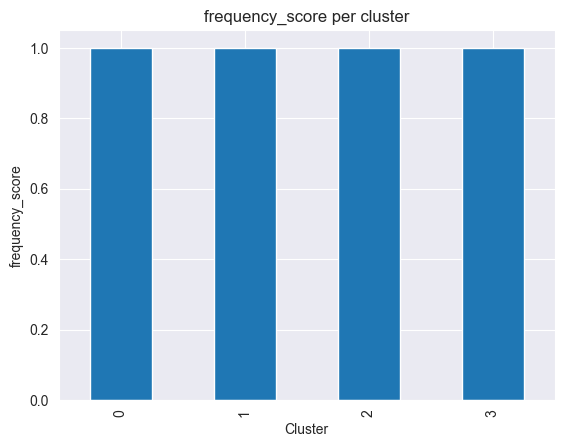

In [143]:
moyennes = X_subset.groupby('cluster')['frequency_score'].mean()

# La façon la plus simple
moyennes.plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('frequency_score')
plt.title('frequency_score per cluster')
plt.show()

Maintenant on peut faire dans le cluster 0 la moyenne des prix, etc...

Comme mon dataframe a plus de 2 colonnes, on doit faire une réduction de la dimension avec une PCA.

In [144]:
# On drop la colonne cluster car il ne faut pas qu'on la mette lors du Dbscan, autrement elle faussera le jeu de données
# Cela introduit du data leakage

X_subset.drop(columns=['cluster'], inplace=True)

### E - Visualisation avec PCA

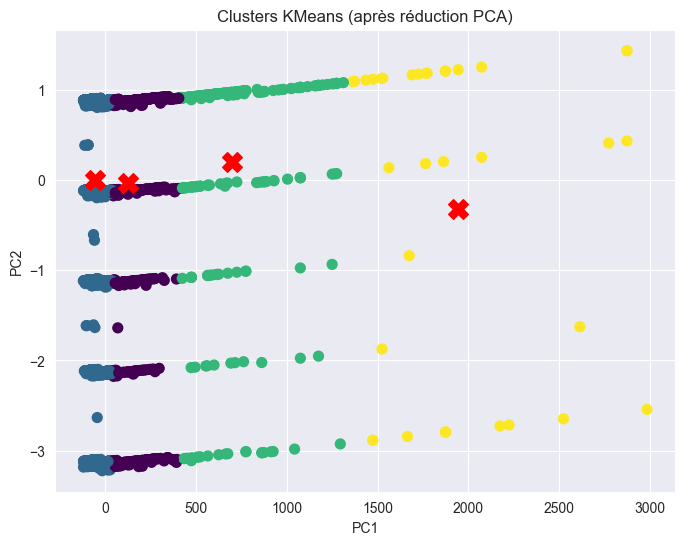

In [145]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_subset)

# Fit et plot avec données réduites
kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(X_pca)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            c='red', marker='X', s=200)
plt.title("Clusters KMeans (après réduction PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


## c) visualisation du kmeans avec les clusters choisis

on prend le nombre de clusters = 4 , et à partir de cela on va runner le kmeans et en faire des plots

objetcitfs : trouver les features qui permettent de décrire les clusters.
            trouver les profils-types pour décrire les clusters clients

In [146]:
X_subset

,mean_price,average_reviewed_score,recency_score,frequency_score,monetary_score
85061,205.000,5.0,1,1,3
3737,189.900,5.0,1,1,3
24828,119.900,5.0,1,1,2
44937,24.500,3.0,1,1,1
9451,147.900,4.0,1,1,2
...,...,...,...,...,...
18572,199.000,5.0,1,1,3
71893,56.990,4.0,1,1,1
77797,18.995,1.0,1,1,1
27670,249.900,5.0,1,1,3


In [147]:
print("Shape des données :", X_subset.shape)


Shape des données : (9927, 5)


=== Analyse K-means complète ===
Shape des données : (300, 4)


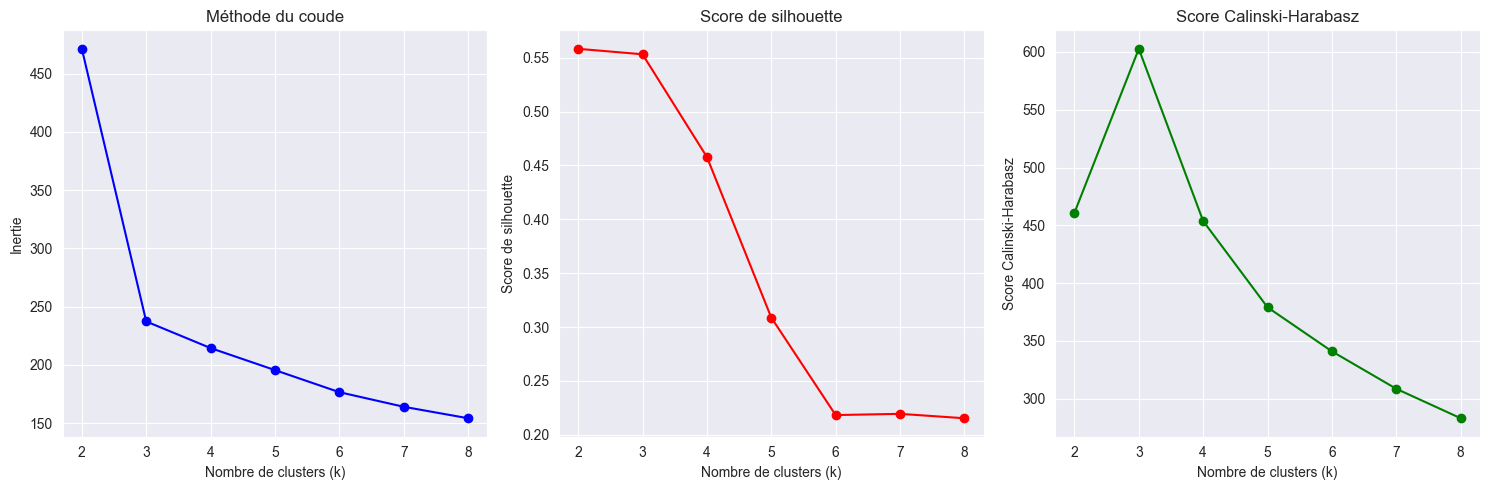

K optimal suggéré (silhouette score) : 2
Nombre de points par cluster :
Cluster 0: 100 points
Cluster 1: 200 points


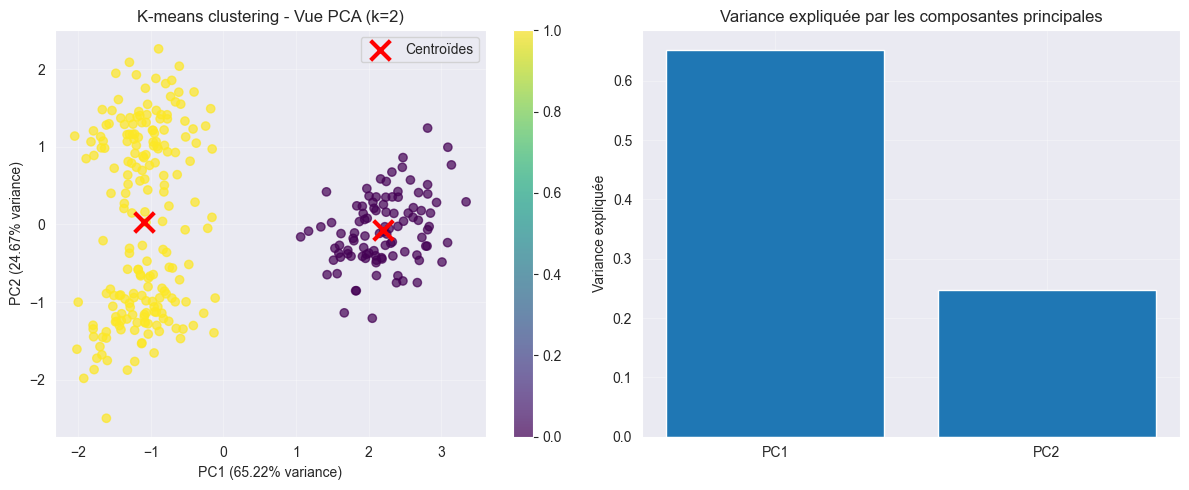


Score de silhouette final : 0.558
Inertie finale : 471.27


In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Supposons que vous avez déjà votre X_subset (DataFrame ou array)
# X_subset = votre_dataframe

def perform_kmeans_analysis(X_subset, max_clusters=10):
    """
    Effectue une analyse K-means complète avec visualisations

    Parameters:
    X_subset : DataFrame ou array, vos données d'entrée
    max_clusters : int, nombre maximum de clusters à tester
    """

    # 1. Préparation des données
    # Standardisation (recommandée pour K-means)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_subset)

    # 2. Détermination du nombre optimal de clusters

    # Méthode du coude (Elbow method)
    inertias = []
    silhouette_scores = []
    calinski_scores = []

    K_range = range(2, max_clusters + 1)

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)

        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
        calinski_scores.append(calinski_harabasz_score(X_scaled, kmeans.labels_))

    # Visualisation des métriques pour choisir k optimal
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Méthode du coude
    axes[0].plot(K_range, inertias, 'bo-')
    axes[0].set_xlabel('Nombre de clusters (k)')
    axes[0].set_ylabel('Inertie')
    axes[0].set_title('Méthode du coude')
    axes[0].grid(True)

    # Score de silhouette
    axes[1].plot(K_range, silhouette_scores, 'ro-')
    axes[1].set_xlabel('Nombre de clusters (k)')
    axes[1].set_ylabel('Score de silhouette')
    axes[1].set_title('Score de silhouette')
    axes[1].grid(True)

    # Score de Calinski-Harabasz
    axes[2].plot(K_range, calinski_scores, 'go-')
    axes[2].set_xlabel('Nombre de clusters (k)')
    axes[2].set_ylabel('Score Calinski-Harabasz')
    axes[2].set_title('Score Calinski-Harabasz')
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

    # Suggérer le k optimal basé sur le score de silhouette
    optimal_k = K_range[np.argmax(silhouette_scores)]
    print(f"K optimal suggéré (silhouette score) : {optimal_k}")

    return optimal_k, X_scaled, scaler

def visualize_kmeans(X_scaled, k, original_X=None, feature_names=None):
    """
    Visualise les résultats du K-means

    Parameters:
    X_scaled : array, données standardisées
    k : int, nombre de clusters
    original_X : DataFrame optionnel, données originales pour les noms de features
    feature_names : list optionnel, noms des features
    """

    # Appliquer K-means avec k optimal
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    centroids = kmeans.cluster_centers_

    print(f"Nombre de points par cluster :")
    unique, counts = np.unique(cluster_labels, return_counts=True)
    for cluster, count in zip(unique, counts):
        print(f"Cluster {cluster}: {count} points")

    # Réduction de dimensionnalité avec PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    centroids_pca = pca.transform(centroids)

    plt.figure(figsize=(12, 5))

    # Graphique PCA avec clusters
    plt.subplot(1, 2, 1)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                        c=cluster_labels, cmap='viridis', alpha=0.7)
    plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1],
               c='red', marker='x', s=200, linewidths=3, label='Centroïdes')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.title(f'K-means clustering - Vue PCA (k={k})')
    plt.colorbar(scatter)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Graphique de la variance expliquée
    plt.subplot(1, 2, 2)
    plt.bar(['PC1', 'PC2'], pca.explained_variance_ratio_)
    plt.ylabel('Variance expliquée')
    plt.title('Variance expliquée par les composantes principales')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return kmeans, cluster_labels

# Exemple d'utilisation
if __name__ == "__main__":
    # Créons un exemple de données pour la démonstration
    np.random.seed(42)
    n_samples = 300

    # Générer des données d'exemple avec 4 features
    X_subset_example = pd.DataFrame({
        'feature1': np.concatenate([
            np.random.normal(2, 1, n_samples//3),
            np.random.normal(6, 1, n_samples//3),
            np.random.normal(4, 1, n_samples//3)
        ]),
        'feature2': np.concatenate([
            np.random.normal(3, 1, n_samples//3),
            np.random.normal(7, 1, n_samples//3),
            np.random.normal(1, 1, n_samples//3)
        ]),
        'feature3': np.concatenate([
            np.random.normal(1, 0.5, n_samples//3),
            np.random.normal(3, 0.5, n_samples//3),
            np.random.normal(2, 0.5, n_samples//3)
        ]),
        'feature4': np.concatenate([
            np.random.normal(5, 1, n_samples//3),
            np.random.normal(2, 1, n_samples//3),
            np.random.normal(8, 1, n_samples//3)
        ])
    })

    print("=== Analyse K-means complète ===")
    print(f"Shape des données : {X_subset_example.shape}")

    # 1. Analyser et trouver k optimal
    optimal_k, X_scaled, scaler = perform_kmeans_analysis(X_subset_example, max_clusters=8)

    # 2. Visualiser avec k optimal
    kmeans_model, labels = visualize_kmeans(
        X_scaled,
        optimal_k,
        original_X=X_subset_example,
        feature_names=X_subset_example.columns.tolist()
    )

    print(f"\nScore de silhouette final : {silhouette_score(X_scaled, labels):.3f}")
    print(f"Inertie finale : {kmeans_model.inertia_:.2f}")

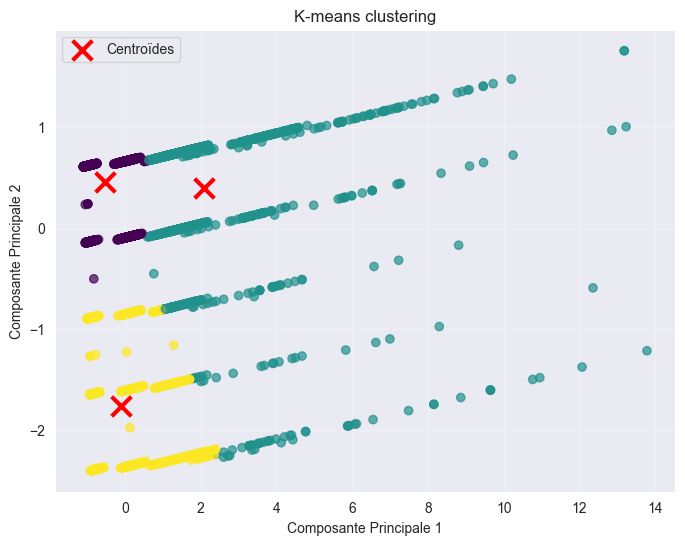

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Supposons que X_subset est votre DataFrame
# X_subset = pd.read_csv('votre_fichier.csv')  # Remplacez par votre méthode de chargement de données

# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_subset)

# Appliquer K-means avec un nombre de clusters choisi (par exemple, 3)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(X_scaled)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Réduction de dimensionnalité avec PCA pour la visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
centroids_pca = pca.transform(centroids)

# Visualiser les résultats
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='x', s=200, linewidths=3, label='Centroïdes')
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.title('K-means clustering')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## C - Dbscan

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) est un algorithme de clustering basé sur la densité.  
Au lieu de diviser les données en k clusters prédéfinis, DBSCAN identifie des zones denses de points et considère les points isolés comme du bruit (outliers).

Avantages par rapport à K-means :

Pas besoin de spécifier le nombre de clusters à l'avance
Peut détecter des clusters de formes arbitraires (pas seulement sphériques)
Identifie automatiquement les outliers
Résistant au bruit dans les données

Paramètres clés :

eps (ε) : rayon de voisinage - distance maximale entre deux points pour qu'ils soient considérés comme voisins
min_samples : nombre minimum de points dans un voisinage pour former un cluster

Types de points :

Core points : ont au moins min_samples voisins dans leur rayon eps
Border points : dans le voisinage d'un core point mais n'ont pas assez de voisins
Noise points : ni core ni border (outliers, étiquetés -1)

In [150]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_subset)

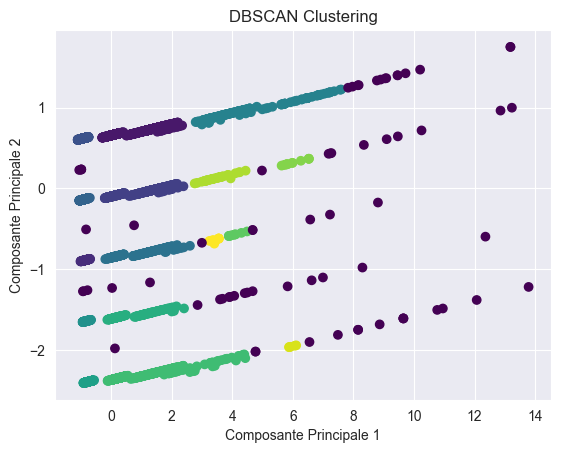

In [151]:
# Réduction de dimensionnalité avec PCA pour la visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Appliquer DBSCAN aux données réduites
dbscan = DBSCAN(eps=0.3, min_samples=5)  # Ajustez eps et min_samples selon vos besoins
clusters = dbscan.fit_predict(X_pca)

# Plotting
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title("DBSCAN Clustering")
plt.xlabel("Composante Principale 1")
plt.ylabel("Composante Principale 2")
plt.show()


In [152]:
print(clusters)

[ 0  0  0 ...  8  0 -1]


In [153]:
# Filter out noise points (label = -1)
mask = clusters != -1
if len(set(clusters[mask])) > 1:
    score = silhouette_score(X_pca[mask], clusters[mask])
    print("Silhouette Score:", score)
else:
    print("Not enough clusters for silhouette score.")

Silhouette Score: 0.6075555002443062


In [154]:
dbscan

,eps,0.3
,min_samples,5
,metric,'euclidean'
,metric_params,None
,algorithm,'auto'
,leaf_size,30
,p,None
,n_jobs,None


In [155]:
from collections import Counter
import numpy as np
from sklearn.metrics import (
    silhouette_score, silhouette_samples,
    calinski_harabasz_score, davies_bouldin_score,
    adjusted_rand_score, adjusted_mutual_info_score
)

# clusters est votre tableau de labels DBSCAN (ex: clusters = dbscan.fit_predict(X_pca) ou X_scaled)
labels = clusters  # ou dbscan.labels_
X_for_scoring = X_scaled  # ou X_pca si vous voulez absolument sur les composantes

# Indicateurs DBSCAN / basiques
n_points = len(labels)
n_noise = np.sum(labels == -1)
unique_labels = set(labels)
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
pct_noise = 100.0 * n_noise / n_points

print(f"Points total: {n_points}")
print(f"Clusters trouvés (excluant bruit): {n_clusters}")
print(f"Points bruit: {n_noise} ({pct_noise:.2f}%)")

scores = {}

# Silhouette : vérifiez d'abord qu'on a au moins 2 clusters valides
if n_clusters >= 2:
    # Option A : silhouette sur tous les points (traite -1 comme un cluster)
    try:
        scores['silhouette_all'] = silhouette_score(X_for_scoring, labels)
    except Exception as e:
        scores['silhouette_all'] = f"Erreur: {e}"

    # Option B (recommandée) : silhouette **sans** les points bruit
    mask_core = labels != -1
    if np.sum(mask_core) >= 2 and len(set(labels[mask_core])) >= 2:
        scores['silhouette_no_noise'] = silhouette_score(X_for_scoring[mask_core], labels[mask_core])
    else:
        scores['silhouette_no_noise'] = "Pas assez de points/clusters sans bruit"

    # distribution dessilhouette par échantillon si besoin:
    # sample_sil = silhouette_samples(X_for_scoring[mask_core], labels[mask_core])
else:
    scores['silhouette_all'] = "Impossible (moins de 2 clusters)"
    scores['silhouette_no_noise'] = "Impossible"

# Calinski-Harabasz et Davies-Bouldin (nécessitent ≥2 clusters)
if n_clusters >= 2:
    try:
        scores['calinski_harabasz'] = calinski_harabasz_score(X_for_scoring, labels)
    except Exception as e:
        scores['calinski_harabasz'] = f"Erreur: {e}"
    try:
        scores['davies_bouldin'] = davies_bouldin_score(X_for_scoring, labels)
    except Exception as e:
        scores['davies_bouldin'] = f"Erreur: {e}"
else:
    scores['calinski_harabasz'] = "Impossible"
    scores['davies_bouldin'] = "Impossible"

# Si vous avez y_true (étiquettes réelles), calculez ARI/AMI
# if 'y_true' in globals():
#     scores['ARI'] = adjusted_rand_score(y_true, labels)
#     scores['AMI'] = adjusted_mutual_info_score(y_true, labels)

# Affichage
for k, v in scores.items():
    print(f"{k}: {v}")


Points total: 9927
Clusters trouvés (excluant bruit): 16
Points bruit: 70 (0.71%)
silhouette_all: 0.5618032434726443
silhouette_no_noise: 0.5691431083629789
calinski_harabasz: 3269.1085503718955
davies_bouldin: 1.4084652681380745


Silhouette Score: 0.7806346373448323
Silhouette Score: 0.7937390384270413
Silhouette Score: 0.7942452814056933
Silhouette Score: 0.7936362258035726
Silhouette Score: 0.7934413924019212
Silhouette Score: 0.7934272765989782
Silhouette Score: 0.6461424047176653
Silhouette Score: 0.6486403752249013
Silhouette Score: 0.6171881567034226
Silhouette Score: 0.6171048078326661


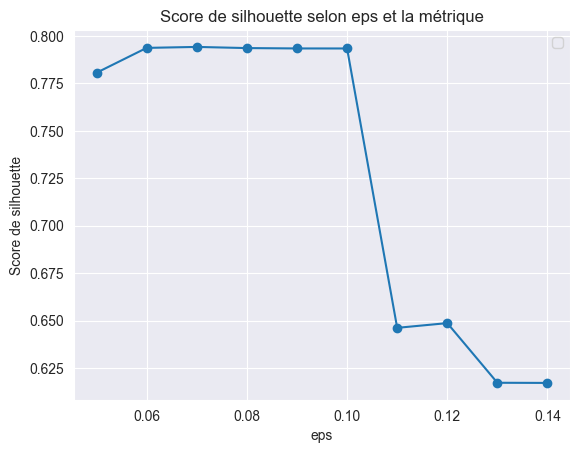

In [156]:
# 2️⃣ Paramètres à tester
eps_values = np.arange(0.05, 0.15, 0.01)

#metrics = ['manhattan', 'chebyshev', 'euclidian']

# 3️⃣ Stockage des résultats
results = []

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=5)
    clusters = db.fit_predict(X_pca)


    mask = clusters != -1
    if len(set(clusters[mask])) > 1:
        score = silhouette_score(X_pca[mask], clusters[mask])
        print("Silhouette Score:", score)
        results.append((eps, score))
    else:
        print("Not enough clusters for silhouette score.")
        

# Séparer les tuples en deux listes : x et y
eps_list, score_silhouette_list = zip(*results)  # unzip

# Tracer
plt.plot(eps_list, score_silhouette_list, marker='o')  # marker pour voir les points

plt.title("Score de silhouette selon eps et la métrique")
plt.xlabel("eps")
plt.ylabel("Score de silhouette")
plt.legend()
plt.show()


On a un score optimal avec 0.06. C'est ma distance optimale de clustering pour le DB Scan.   

Refaison le dbscan avec le paramètre optimal trouvé pour comparer les réultats

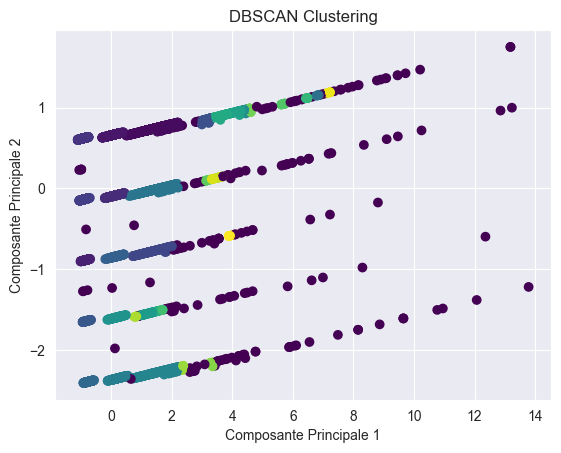

In [157]:
# Réduction de dimensionnalité avec PCA pour la visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Appliquer DBSCAN aux données réduites
dbscan = DBSCAN(eps=0.06, min_samples=5)  # Ajustez eps et min_samples selon vos besoins
clusters = dbscan.fit_predict(X_pca)

# Plotting
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title("DBSCAN Clustering")
plt.xlabel("Composante Principale 1")
plt.ylabel("Composante Principale 2")
plt.show()

Là on obtient que des scores négatives. Cela montre que le score epsilon est mauvais, il n'arrive pas à différencier des clusters.

On crée une séparation tous les 6 mois, ensuite on va run l'algorithme de k-means, et vérifier qu'on obtient des clusters similaires

On fait des clusters tous les 6 mois car cela correspond aux saisons d'hiver et d'été

" En utilisant des méthodes graphiques" par ex verifier que les clusters sont à peu près les mêmes.   
Avec le test de Kolmogorov-Smirnov, on peut faire la silhouette et dire que les métriques de S1 2016 et de S1 2017 sont à peu près les mêmes.   

Interprétables d'un point de vue métier. Quelles sont les pistes d'action pour ça : cluster 3 , clienrts qui ont acheté beauycup, cluster 1, ils ont fait des petits achats, donc on peut les sensibiliser avec des campagnes de pub ou quoi

Prendre 4 clusters car d'un point de vue métier c'est plus simple. 

# 3 - Conclusion

- dire que le nb de 4 clusters est optimal d'un point de vue métier + explication
- définir une stratégie marketiing à partir des clusters identifiés (campagne de mail, etc ...) (ex : les personnes non connectées depuis longtemps, leru envoyer des rappels par mail, les gros achteurs, les inviter à des events ...)
- conclure sur la stabilité temporelle

A faire : k-means, dbscan, dendogramm.  
Evaluer les métriques (ex: distance intra et inter cluster, diagramme du coude).  
Evaluer les clusters en eux-mêmes.  
Faire des bar plots par cluster.    
Tester différentes combinaisons de kmeans.    
Afficher les labels et les clusters.    